# Deduplication Example

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from importlib import reload
import logging
import torch
import json
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys
sys.path.insert(0, '..')

In [ ]:
import entity_embed_local
from entity_embed_local import EntityEmbedLocal


In [5]:
import torch
torch.set_num_threads(1)

import numpy as np
import pandas as pd

random_seed = 40
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Load Dataset

Let's download the CSV dataset to a temporary directory:

In [ ]:
data = pd.read_csv('data/alias_data.csv',names=['merchant_name','merchant_id','plaid_merchant','plaid_category','avg_tx_amount','count'])
dataset = data.groupby('merchant_id').head(200)
dataset.avg_tx_amount = dataset.avg_tx_amount.round()
dataset = dataset.astype(str)
# dataset = dataset[dataset.merchant_id.isin(dataset.merchant_id.unique()[:50000])]
dataset['cluster_id'] = pd.factorize(dataset['merchant_id'].tolist())[0]


In [8]:
mapping = pd.Series(dataset.merchant_name.values,index=dataset.cluster_id).to_dict()


In [9]:

record_dict = {}
cluster_field = 'cluster_id'

for current_record_id, record in dataset[['cluster_id','merchant_name','plaid_merchant','plaid_category','avg_tx_amount']].iterrows():
    record['id'] = current_record_id
    record[cluster_field] = int(record[cluster_field])  # convert cluster_field to int
    record_dict[current_record_id] = record.to_dict()

How many clusters this dataset has?

In [10]:
cluster_total = len(set(record[cluster_field] for record in record_dict.values()))
cluster_total

35104

From all clusters, we'll use only 50% for training, and other 15% for validation to test how well we can generalize:

In [11]:
from data_utils import utils

train_record_dict, valid_record_dict, test_record_dict = utils.split_record_dict_on_clusters(
    record_dict=record_dict,
    cluster_field=cluster_field,
    train_proportion=0.60,
    valid_proportion=0.15,
    random_seed=random_seed)

12:55:26 INFO:Singleton cluster sizes (train, valid, test):(18649, 4662, 7772)
12:55:26 INFO:Plural cluster sizes (train, valid, test):(2412, 603, 1006)


Note we're splitting the data on **clusters**, not records, so the record counts vary:

In [12]:
len(train_record_dict), len(valid_record_dict), len(test_record_dict)

(26719, 6591, 11098)

## Preprocess

We'll perform a very minimal preprocessing of the dataset. We want to simply force ASCII chars, lowercase all chars, and strip leading and trailing whitespace.

The fields we'll clean are the ones we'll use:

In [13]:
field_list = ['merchant_name','plaid_merchant','plaid_category','avg_tx_amount']

In [14]:
import unidecode

def clean_str(s):
    return unidecode.unidecode(s).lower().strip()

for record in record_dict.values():
    for field in field_list:
        record[field] = clean_str(record[field])

In [15]:
utils.subdict(record_dict[2], field_list)

{'merchant_name': 'dutchbrosll',
 'plaid_merchant': 'dutch bros. coffee',
 'plaid_category': 'food and drink restaurants coffee shop',
 'avg_tx_amount': '-10.0'}

Forcing ASCII chars in this dataset is useful to improve recall because there's little difference between accented and not-accented chars here. Also, this dataset contains mostly latin chars.

## Configure Entity Embed fields

Now we will define how record fields will be numericalized and encoded by the neural network. First we set an `alphabet`, here we'll use ASCII numbers, letters, symbols and space:

In [16]:
from data_utils.field_config_parser import DEFAULT_ALPHABET

alphabet = DEFAULT_ALPHABET
''.join(alphabet)

'0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

It's worth noting you can use any alphabet you need, so the accent removal we performed is optional.

Then we set an `field_config_dict`. It defines `field_type`s that determine how fields are processed in the neural network:

In [17]:
field_config_dict = {
    
    'merchant_name': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },

    'merchant_name_semantic': {
        'key': 'merchant_name',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "tx_embeddings_large.vec",
        'max_str_len': None,  # compute
    },
     'avg_tx_amount': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'avg_tx_amount_semantic': {
        'key':"avg_tx_amount",
        'field_type': "SEMANTIC_STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "tx_embeddings_large.vec",
        'max_str_len': None,  # compute
    },
    'plaid_merchant': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'plaid_merchant_semantic': {
        'key': 'plaid_merchant',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "tx_embeddings_large.vec",
    },
    'plaid_category': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'plaid_category_semantic': {
        'key': 'plaid_category',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "tx_embeddings_large.vec",
    },
}

Then we use our `field_config_dict` to get a `record_numericalizer`. This object will convert the strings from our records into tensors for the neural network.

The same `record_numericalizer` must be used on ALL data: train, valid, test. This ensures numericalization will be consistent. Therefore, we pass `record_list=record_dict.values()`:

In [18]:
from data_utils.field_config_parser import FieldConfigDictParser

record_numericalizer = FieldConfigDictParser.from_dict(field_config_dict, record_list=record_dict.values())

12:55:27 INFO:For field=merchant_name, computing actual max_str_len
12:55:27 INFO:actual_max_str_len=23 must be even to enable NN pooling. Updating to 24
12:55:27 INFO:For field=merchant_name, using actual_max_str_len=24
12:55:27 INFO:Loading vectors from /Users/adnanshahzada/Cleo/Repos/deduplication/entity-embed/entity_embed/.vector_cache/tx_embeddings_large.vec.pt
12:55:29 INFO:For field=avg_tx_amount, computing actual max_str_len
12:55:29 INFO:For field=avg_tx_amount, using actual_max_str_len=8
12:55:29 INFO:Loading vectors from /Users/adnanshahzada/Cleo/Repos/deduplication/entity-embed/entity_embed/.vector_cache/tx_embeddings_large.vec.pt
12:55:30 INFO:For field=plaid_merchant, computing actual max_str_len
12:55:30 INFO:actual_max_str_len=23 must be even to enable NN pooling. Updating to 24
12:55:30 INFO:For field=plaid_merchant, using actual_max_str_len=24
12:55:31 INFO:Loading vectors from /Users/adnanshahzada/Cleo/Repos/deduplication/entity-embed/entity_embed/.vector_cache/tx_em

## Initialize Data Module

under the hood, Entity Embed uses [pytorch-lightning](https://pytorch-lightning.readthedocs.io/en/latest/), so we need to create a datamodule object:

In [19]:
from entity_embed import DeduplicationDataModule

batch_size = 32
eval_batch_size = 64
datamodule = DeduplicationDataModule(
    train_record_dict=train_record_dict,
    valid_record_dict=valid_record_dict,
    test_record_dict=test_record_dict,
    cluster_field=cluster_field,
    record_numericalizer=record_numericalizer,
    batch_size=batch_size,
    eval_batch_size=eval_batch_size,
    random_seed=random_seed,
    train_loader_kwargs ={"num_workers":0,"multiprocessing_context":"fork"},
    eval_loader_kwargs ={"num_workers":0,"multiprocessing_context":"fork"},
)

We've used `DeduplicationDataModule` because we're doing Deduplication of a single dataset/table (a.k.a. Entity Clustering, Entity Resolution, etc.).

We're NOT doing Record Linkage of two datasets here. Check the other notebook [Record-Linkage-Example](./Record-Linkage-Example.ipynb) if you want to learn how to do it with Entity Embed.

## Training

Now the training process! Thanks to pytorch-lightning, it's easy to train, validate, and test with the same datamodule.

We must choose the K of the Approximate Nearest Neighbors, i.e., the top K neighbors our model will use to find duplicates in the embedding space. Below we're setting it on `ann_k` and initializing the `EntityEmbed` model object:

In [29]:
from entity_embed_local import EntityEmbedLocal

ann_k = 15
model = EntityEmbedLocal(
    record_numericalizer,
    ann_k=ann_k,
    embedding_size=100,
    )

setting embedding size to 100


To train, Entity Embed uses [pytorch-lightning Trainer](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) on it's `EntityEmbed.fit` method.

Since Entity Embed is focused in recall, we'll use `valid_recall_at_0.3` for early stopping. But we'll set `min_epochs = 5` to avoid a very low precision.

`0.3` here is the threshold for **cosine similarity of embedding vectors**, so possible values are between -1 and 1. We're using a validation metric, and the training process will run validation on every epoch end due to `check_val_every_n_epoch=1`.

We also set `tb_name` and `tb_save_dir` to use Tensorboard. Run `tensorboard --logdir notebooks/tb_logs` to check the train and valid metrics during and after training.

In [30]:

trainer = model.fit(
    datamodule,
    min_epochs=2,
    max_epochs=5,
    check_val_every_n_epoch=1,
    early_stop_monitor="valid_recall_at_0.7",
    model_save_dir='models',
    use_gpu=False,
)


13:50:27 INFO:GPU available: False, used: False
13:50:27 INFO:TPU available: False, using: 0 TPU cores


calling up trainer....


13:51:20 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 6.6 M 
1 | loss_fn     | SupConLoss | 0     
-------------------------------------------
2.3 M     Trainable params
4.3 M     Non-trainable params
6.6 M     Total params
26.554    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1019/1019 [04:07<00:00,  4.12it/s, loss=0.818, v_num=27]

14:10:50 INFO:Loading the best validation model from /Users/adnanshahzada/Cleo/Repos/deduplication/entity-embed/entity_embed/models/epoch=1-step=1832-v7.ckpt...



setting embedding size to 100


In [35]:
# !mkdir -p models/entityembed
!cp {model.trainer.checkpoint_callback.best_model_path} models/entityembed/ee-model.ckpt

In [30]:
path = "models/entityembed/"

with open(path+ 'ee-train-records.json', 'w') as f:
    json.dump(datamodule.train_record_dict, f, indent=4)

with open(path+ 'ee-valid-records.json', 'w') as f:
    json.dump(datamodule.valid_record_dict, f, indent=4)

with open(path+ 'ee-test-records.json', 'w') as f:
    json.dump(datamodule.test_record_dict, f, indent=4)

In [23]:
model = EntityEmbedLocal.load_from_checkpoint('models/epoch=1-step=1832-v7.ckpt')

setting embedding size to 100


`EntityEmbed.fit` keeps only the weights of the best validation model. With them, we can check the best performance on validation set:

In [31]:
model.validate(datamodule) 

{'valid_f1_at_0.3': 0.0,
 'valid_f1_at_0.5': 0.0,
 'valid_f1_at_0.7': 0.0,
 'valid_pair_entity_ratio_at_0.3': 10.15106931594115,
 'valid_pair_entity_ratio_at_0.5': 4.946155012892461,
 'valid_pair_entity_ratio_at_0.7': 1.6895191870165327,
 'valid_precision_at_0.3': 0.0,
 'valid_precision_at_0.5': 0.0,
 'valid_precision_at_0.7': 0.0,
 'valid_recall_at_0.3': 0.0,
 'valid_recall_at_0.5': 0.0,
 'valid_recall_at_0.7': 0.0}

And we can check which fields are most important for the final embedding:

In [28]:
model.get_pool_weights()

{'merchant_name': 0.2551257014274597,
 'merchant_name_semantic': 0.22146005928516388,
 'avg_tx_amount': 0.03779561445116997,
 'avg_tx_amount_semantic': 0.24249973893165588,
 'plaid_merchant': 0.07616355270147324,
 'plaid_merchant_semantic': 0.060125213116407394,
 'plaid_category': 0.07688859850168228,
 'plaid_category_semantic': 0.02994149550795555}

## Testing

Again with the best validation model, we can check the performance on the test set:

In [30]:
model.test(datamodule)

16:57:02 INFO:Test positive pair count: 30657


{'test_f1_at_0.3': 0.0,
 'test_f1_at_0.5': 0.0,
 'test_f1_at_0.7': 0.0,
 'test_pair_entity_ratio_at_0.3': 17.187250554323725,
 'test_pair_entity_ratio_at_0.5': 5.513303769401331,
 'test_pair_entity_ratio_at_0.7': 2.3838137472283814,
 'test_precision_at_0.3': 0.0,
 'test_precision_at_0.5': 0.0,
 'test_precision_at_0.7': 0.0,
 'test_recall_at_0.3': 0.0,
 'test_recall_at_0.5': 0.0,
 'test_recall_at_0.7': 0.0}

Entity Embed achieves Recall of ~0.99 with Pair-Entity ratio below 100 on a variety of datasets. **Entity Embed aims for high recall at the expense of precision. Therefore, this library is suited for the Blocking/Indexing stage of an Entity Resolution pipeline.**  A scalabale and noise-tolerant Blocking procedure is often the main bottleneck for performance and quality on Entity Resolution pipelines, so this library aims to solve that. Note the ANN search on embedded records returns several candidate pairs that must be filtered to find the best matching pairs, possibly with a pairwise classifier. See the [Record-Linkage-Example](./Record-Linkage-Example.ipynb) for an example of matching.

## t-sne visualization

Let's visualize a small sample of the test embeddings and see if they look properly clustered. First, get the embedding vectors:

In [102]:
test_vector_dict = model.predict(
    record_dict=test_record_dict,
    batch_size=eval_batch_size
)

# batch embedding: 100%|██████████| 286/286 [00:57<00:00,  4.95it/s]


Then, produce the visualization:

In [103]:
vis_sample_size = 10

In [104]:
n=20
test_cluster_dict = utils.record_dict_to_cluster_dict(test_record_dict, cluster_field)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[n:vis_sample_size+n])

vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [105]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=20, square_distances=True, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

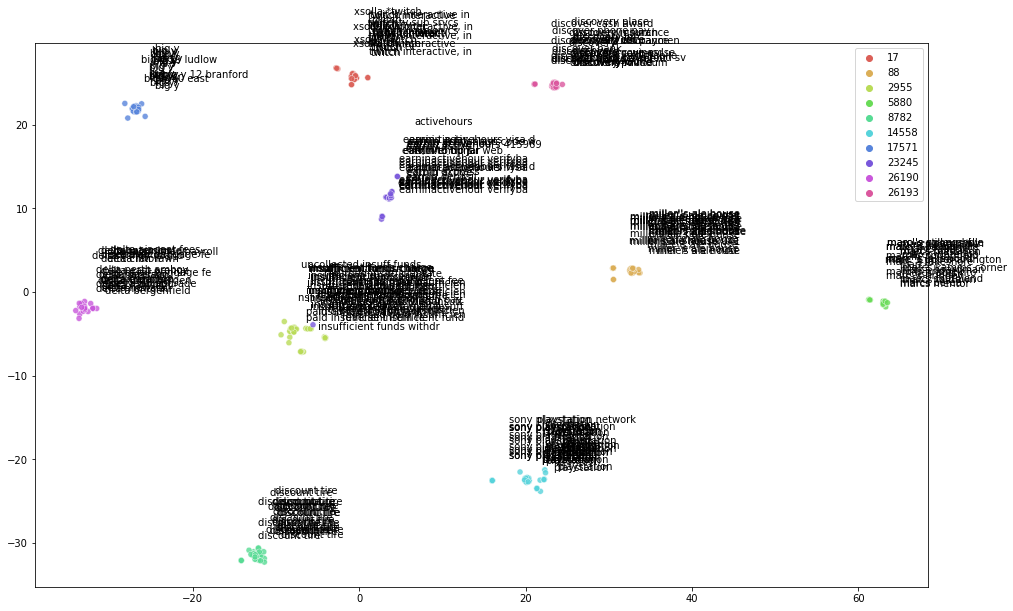

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_record_dict[id_]['alias'][:25]
    ax.text(x + 2 , y + 2+ (5*random.random()), text)

## Testing manually (like a production run)

When running in production, you only have access to the trained `model` object and the production `record_dict` (without the `cluster_field` filled, of course).

So let's simulate that by removing `cluster_field` from the `test_record_dict`:

In [20]:
import copy

prod_test_record_dict = copy.deepcopy(test_record_dict)

for record in prod_test_record_dict.values():
    del record[cluster_field]

In [21]:
prod_test_record_dict = {}

merchants_list = pd.read_csv('data/us_companies.csv', header=None,names=['merchant_name']).iloc[:,0].tolist()
merchants_list

merchants = pd.read_csv('data/merchants_list.csv',names=["merchant_name","merchant_id","plaid_merchant","plaid_category","avg_tx_amount","count"])
merchants = merchants.sort_values('count', ascending=False).drop_duplicates(['merchant_name','merchant_id'])
merchants.avg_tx_amount = merchants.avg_tx_amount.round()
merchants = merchants.apply(lambda x: x.astype(str).str.lower()).reset_index()
for current_record_id, record in merchants.iterrows():
    prod_test_record_dict[current_record_id] = record.to_dict()


Then call `predict_pairs` with some `ann_k` and `sim_threshold`:

In [24]:
sim_threshold = 0.85
ann_k=15
found_pair_set = model.predict_pairs(
    record_dict=prod_test_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold
)
len(found_pair_set)

# batch embedding: 100%|██████████| 592/592 [00:56<00:00, 10.52it/s]


72547

In [25]:
total_merchants = merchants.merchant_name.nunique()
total_merchants


37865

In [ ]:
idf_df = pd.read_csv('data/idf_weights.csv')
idf_weights = dict(zip(idf_df.token,idf_df.idf))


In [291]:
def calculate_genericity(tokens_left,tokens_right):
    tokens = tokens_left + tokens_right
    return  (sum([1-idf_weights.get(t,1) for t in tokens])/len(tokens))

def calculate_amount_similarity(l_amount, r_amount):
    if max(l_amount,r_amount) == 0 or l_amount * r_amount < 0:
        return False
    l_amount, r_amount = (abs(n) for n in (l_amount, r_amount))
    is_different_bracket = abs(l_amount - r_amount) > 10
    is_ratio_large = (min(l_amount , r_amount)/ max(l_amount , r_amount)) < 0.8
    return is_different_bracket or is_ratio_large
# calculate_genericity(prod_test_record_dict.get(3256)['merchant_name'].split(),prod_test_record_dict.get(12722)['merchant_name'].split())
# calculate_amount_similarity(82.0, -100.0)

In [302]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from tqdm.notebook import tqdm

graph = np.zeros((total_merchants,total_merchants))

for (id_left, id_right, similarity) in tqdm(list(found_pair_set)):
    is_different_category = prod_test_record_dict.get(id_left)['plaid_category'].strip() != prod_test_record_dict.get(id_right)['plaid_category'].strip()
    genericity = calculate_genericity(prod_test_record_dict.get(id_left)['merchant_name'].split(),prod_test_record_dict.get(id_right)['merchant_name'].split())
    is_avg_amount_different= calculate_amount_similarity(float(prod_test_record_dict.get(id_left)['avg_tx_amount']),float(prod_test_record_dict.get(id_left)['avg_tx_amount']))
    score = similarity - (is_different_category * 0.1) - (0.5 * genericity) - (is_avg_amount_different * 0.05)
    
    if score >0.85 :
        # print(prod_test_record_dict.get(id_left))
        # print(prod_test_record_dict.get(id_right))
        # print(score)
        # print("------------------")
        graph[id_left,id_right] = 1
    


  0%|          | 0/72547 [00:00<?, ?it/s]

In [304]:
graph = csr_matrix(graph)
# print(graph)

In [305]:
n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
(n_components,labels)

(35960, array([    0,     1,     2, ..., 35957, 35958, 35959], dtype=int32))

In [306]:
dup_cluster = []
for i in tqdm(range(len(labels))):
    dupes = list(np.where(labels==i)[0])
    if len(dupes) > 1:
        dup_cluster.append([prod_test_record_dict.get(key) for key in dupes])
        

  0%|          | 0/37865 [00:00<?, ?it/s]

In [ ]:
'\n'.join(pd.Series(dup_cluster).iloc[0])

In [337]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    (pd.DataFrame(dup_cluster).apply(lambda x: '\n'.join(x.dropna().astype(str)), axis=1)).to_csv('data/dupes.csv')


In [32]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(prod_test_record_dict))

1.6537699722699062

Let's check now the metrics of the found duplicate pairs:

In [55]:
cos_similarity = lambda a, b: np.dot(a, b)

In [35]:
fields = ['merchant_name',
 'plaid_merchant',
 'plaid_category',
 'avg_tx_amount','count']

In [36]:
from tqdm.notebook import tqdm
duplicates = pd.DataFrame(columns=['matching_similarity','merchant','matched_merchant'])
for (id_left, id_right, similarity) in tqdm(list(found_pair_set)):
    merchant_a = utils.subdict(prod_test_record_dict[id_left], fields)
    merchant_b = utils.subdict(prod_test_record_dict[id_right], fields)
    duplicates = duplicates.append({'matching_similarity':similarity,'merchant':merchant_a,'matched_merchant':(merchant_b['merchant_name'],merchant_b['avg_tx_amount'],merchant_b['count'])},ignore_index=True)

duplicates

  0%|          | 0/72542 [00:00<?, ?it/s]

,matching_similarity,merchant,matched_merchant
0,0.915286,"{'merchant_name': 'carroll county', 'plaid_mer...","(carroll emc, -24.0, 26)"
1,0.868136,"{'merchant_name': 'express fuels', 'plaid_merc...","(express nails, -70.0, 14)"
2,0.905586,"{'merchant_name': 'white', 'plaid_merchant': '...","(white hart inn, -8.0, 1)"
3,0.961777,"{'merchant_name': 'poke city', 'plaid_merchant...","(poke poku, -24.0, 7)"
4,0.977440,"{'merchant_name': 'new china fun', 'plaid_merc...","(new china restaurant, -22.0, 323)"
...,...,...,...
72537,0.865486,"{'merchant_name': 'los', 'plaid_merchant': 'na...","(los cabos, -60.0, 35)"
72538,0.926597,"{'merchant_name': 'mega bev', 'plaid_merchant'...","(mega liquor, -22.0, 121)"
72539,0.902664,"{'merchant_name': 'village inn pizza', 'plaid_...","(village restaurant, -20.0, 20)"
72540,0.882056,"{'merchant_name': 'el amigo', 'plaid_merchant'...","(el sol, -20.0, 19)"


In [45]:
duplicates_strong = duplicates[duplicates.matching_similarity>0.9]
duplicates_strong.matching_similarity = duplicates_strong.matching_similarity.apply(lambda x: round(x,3))
duplicates_strong.merchant = duplicates_strong.merchant.astype(str)
result =duplicates_strong.groupby('merchant').agg(lambda x: list(x))
result.to_csv('data/duplicate_merchants_ct.csv')
result

/Users/adnanshahzada/opt/miniconda3/envs/entity-embed-env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,matching_similarity,matched_merchant
merchant,,
"{'merchant_name': ""america''s best"", 'plaid_merchant': ""america''s best"", 'plaid_category': 'food and drink restaurants ', 'avg_tx_amount': '-107.0', 'count': '1341'}",[0.931],"[(america''s best wings, -22.0, 281)]"
"{'merchant_name': ""auntie anne''s"", 'plaid_merchant': ""auntie anne''s"", 'plaid_category': 'food and drink restaurants ', 'avg_tx_amount': '-10.0', 'count': '22971'}","[0.981, 0.978]","[(auntie annes, -11.0, 17), (auntie annies, -8..."
"{'merchant_name': ""bahama buck''s"", 'plaid_merchant': ""bahama buck''s tx"", 'plaid_category': 'shops clothing and accessories ', 'avg_tx_amount': '-10.0', 'count': '39'}",[0.952],"[(bahama bucks, -11.0, 437)]"
"{'merchant_name': ""baker''s dozen"", 'plaid_merchant': ""baker''s dozen"", 'plaid_category': 'shops food and beverage store ', 'avg_tx_amount': '-12.0', 'count': '4'}",[0.901],"[(baker''s iga, -24.0, 21)]"
"{'merchant_name': ""bill''s liquor"", 'plaid_merchant': ""bill''s liquor"", 'plaid_category': 'shops food and beverage store ', 'avg_tx_amount': '-23.0', 'count': '19'}",[0.921],"[(bill''s superette, -15.0, 232)]"
...,...,...
"{'merchant_name': 'zoom management', 'plaid_merchant': 'nan', 'plaid_category': 'service ', 'avg_tx_amount': '-30.0', 'count': '22'}","[0.903, 0.962, 0.935]","[(zoom tan, -23.0, 208), (zoom mart, -19.0, 14..."
"{'merchant_name': 'zoom mart', 'plaid_merchant': 'nan', 'plaid_category': 'service ', 'avg_tx_amount': '-19.0', 'count': '14'}","[0.95, 0.926]","[(zoom.us, -16.0, 513), (zoom tan, -23.0, 208)]"
"{'merchant_name': 'zoom tan', 'plaid_merchant': 'zoom tan', 'plaid_category': 'service personal care ', 'avg_tx_amount': '-23.0', 'count': '208'}",[0.927],"[(zoom.us, -16.0, 513)]"


In [55]:
idx_a += 20
idx_b += 20
[(r,r in merchants_list) for  r in dataset.iloc[idx_a:idx_b,:]['merchant_name'].tolist()]

[('Baho Convenience Store', False),
 ('Hilton Payroll', False),
 ('Fast Shop', False),
 ('Imperial Mart', False),
 ('Bitterroot Beanery', False),
 ('Piedmont Natural Gas', False),
 ('The Island Shoppe', False),
 ('Americas Best Wings', False),
 ('Rockland Nails', False),
 ('Irobot Corporation', False),
 ('Khalil`s Food & Liquor', False),
 ('Quality Auto Repair', False),
 ('Jackpot Mini Mart', False),
 ('Westside Convenience', False),
 ('H And M Mini Sto', False),
 ('Patel Corner Pantry', False),
 ('Guys Pizza Downtown', False),
 ('Xingyu Restaurant Inc', False),
 ('5801 Video Lounge & Caf', False),
 ('Just Salad', True)]

In [144]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, datamodule.test_pos_pair_set)

(0.7512554540215691, 0.12059282165133735)

Same numbers of the `trainer.test`, so our manual testing is fine.

Finally, we can check the false positives and negatives to see if they're really difficult:

In [145]:
false_positives = list(found_pair_set - datamodule.test_pos_pair_set)
len(false_positives)

12086

In [146]:
false_negatives = list(datamodule.test_pos_pair_set - found_pair_set)
len(false_negatives)

266186

In [ ]:
true_positives = list(found_pair_set - datamodule.test_pos_pair_set)
len(false_positives)
for (id_left, id_right) in list(found_pair_set)[:10]:
    display(
        (
            record_dict[id_left],
            record_dict[id_right],
            cos_similarity(test_vector_dict[id_left], test_vector_dict[id_right]),
            utils.subdict(record_dict[id_left], field_list), utils.subdict(record_dict[id_right], field_list)
        )
    )

In [147]:
for (id_left, id_right) in false_positives[:10]:
    display(
        (
            cos_similarity(test_vector_dict[id_left], test_vector_dict[id_right]),
            utils.subdict(record_dict[id_left], field_list), utils.subdict(record_dict[id_right], field_list)
        )
    )

(0.87486815,
 {'alias': 'r&b tea', 'plaid_merchant': 'r&b tea', 'avg_tx_amount': '-6.35'},
 {'alias': 'r & gs food basket',
  'plaid_merchant': 'r & gs food basket',
  'avg_tx_amount': '-21.83'})

(0.8825392,
 {'alias': 'country wide insurance',
  'plaid_merchant': 'country wide insurance',
  'avg_tx_amount': '-284.13'},
 {'alias': 'country convenie',
  'plaid_merchant': 'country convenie',
  'avg_tx_amount': '-14.1'})

(0.905407,
 {'alias': 'china town 1', 'plaid_merchant': 'nan', 'avg_tx_amount': '-25.0'},
 {'alias': 'china delight chinese',
  'plaid_merchant': 'china delight chinese',
  'avg_tx_amount': '-21.56'})

(0.70510805,
 {'alias': 'blue bay',
  'plaid_merchant': 'blue bay',
  'avg_tx_amount': '-12.96'},
 {'alias': 'blue moon tap house',
  'plaid_merchant': 'blue moon tap house',
  'avg_tx_amount': '-26.07'})

(0.9555845,
 {'alias': 'lincoln highway',
  'plaid_merchant': 'lincoln highway',
  'avg_tx_amount': '-11.24'},
 {'alias': 'lincoln c mart',
  'plaid_merchant': 'lincoln c mart',
  'avg_tx_amount': '-24.99'})

(0.95284754,
 {'alias': 'quick pick grocery ltd',
  'plaid_merchant': 'nan',
  'avg_tx_amount': '-8.98'},
 {'alias': 'quick pick atlanta',
  'plaid_merchant': 'quick pick',
  'avg_tx_amount': '-5.26'})

(0.8914383,
 {'alias': 'china gourmet house',
  'plaid_merchant': 'china gourmet house',
  'avg_tx_amount': '-23.85'},
 {'alias': 'china town 1', 'plaid_merchant': 'nan', 'avg_tx_amount': '-36.75'})

(0.9162289,
 {'alias': 'taco heads fort worth',
  'plaid_merchant': 'taco heads fort worth',
  'avg_tx_amount': '-18.76'},
 {'alias': 'taco monster',
  'plaid_merchant': 'taco monster',
  'avg_tx_amount': '-29.71'})

(0.95120347,
 {'alias': 'noodles pho u',
  'plaid_merchant': 'noodles pho u',
  'avg_tx_amount': '-33.58'},
 {'alias': 'noodles & company',
  'plaid_merchant': 'noodles & company',
  'avg_tx_amount': '-30.15'})

(0.9241347,
 {'alias': 'noodles and dumplings',
  'plaid_merchant': 'noodles and dumplings',
  'avg_tx_amount': '-48.14'},
 {'alias': 'noodles & company',
  'plaid_merchant': 'noodles & company',
  'avg_tx_amount': '-8.7'})

In [149]:
for (id_left, id_right) in false_negatives[:30]:
    display(
        (
            cos_similarity(test_vector_dict[id_left], test_vector_dict[id_right]),
            utils.subdict(record_dict[id_left], field_list), utils.subdict(record_dict[id_right], field_list)
        )
    )

(0.99850756,
 {'alias': 'kwik trip',
  'plaid_merchant': 'kwik trip',
  'avg_tx_amount': '-20.42'},
 {'alias': 'kwik trip',
  'plaid_merchant': 'kwik trip',
  'avg_tx_amount': '-18.5'})

(0.99695677,
 {'alias': 'rent-a-center',
  'plaid_merchant': 'rent-a-center',
  'avg_tx_amount': '-121.85'},
 {'alias': 'rent-a-center',
  'plaid_merchant': 'rent-a-center',
  'avg_tx_amount': '-38.35'})

(0.9966733,
 {'alias': 'kwik trip',
  'plaid_merchant': 'kwik trip',
  'avg_tx_amount': '-17.18'},
 {'alias': 'kwik trip',
  'plaid_merchant': 'kwik trip',
  'avg_tx_amount': '-26.18'})

(0.97021323,
 {'alias': 'cardtronics', 'plaid_merchant': 'nan', 'avg_tx_amount': '-43.5'},
 {'alias': 'cardtronics',
  'plaid_merchant': 'cardtronics',
  'avg_tx_amount': '-41.16'})

(0.9971533,
 {'alias': 'stop & shop',
  'plaid_merchant': 'stop & shop',
  'avg_tx_amount': '-23.7'},
 {'alias': 'stop & shop',
  'plaid_merchant': 'stop & shop',
  'avg_tx_amount': '-7.62'})

(0.99700713,
 {'alias': 'wawa', 'plaid_merchant': 'wawa', 'avg_tx_amount': '-18.72'},
 {'alias': 'wawa', 'plaid_merchant': 'wawa', 'avg_tx_amount': '-20.54'})

(0.9975728,
 {'alias': "dave & buster''s",
  'plaid_merchant': 'dave & busters',
  'avg_tx_amount': '-35.75'},
 {'alias': "dave & buster''s",
  'plaid_merchant': 'dave & busters',
  'avg_tx_amount': '-77.44'})

(0.9961077,
 {'alias': 'kwik trip',
  'plaid_merchant': 'kwik trip',
  'avg_tx_amount': '-14.02'},
 {'alias': 'kwik trip',
  'plaid_merchant': 'kwik trip',
  'avg_tx_amount': '-9.2'})

(0.99612856,
 {'alias': "dave & buster''s",
  'plaid_merchant': 'dave & busters',
  'avg_tx_amount': '-46.28'},
 {'alias': "dave & buster''s",
  'plaid_merchant': "dave & buster''s",
  'avg_tx_amount': '-33.63'})

(0.9968643,
 {'alias': 'tractor supply',
  'plaid_merchant': 'tractor supply',
  'avg_tx_amount': '-28.6'},
 {'alias': 'tractor supply',
  'plaid_merchant': 'tractor supply',
  'avg_tx_amount': '-54.1'})

(0.9972248,
 {'alias': 'stop & shop',
  'plaid_merchant': 'stop & shop',
  'avg_tx_amount': '-32.71'},
 {'alias': 'stop & shop',
  'plaid_merchant': 'stop & shop',
  'avg_tx_amount': '-10.57'})

(0.9969662,
 {'alias': 'cardtronics',
  'plaid_merchant': 'cardtronics',
  'avg_tx_amount': '-184.65'},
 {'alias': 'cardtronics',
  'plaid_merchant': 'cardtronics',
  'avg_tx_amount': '-52.5'})

(0.9916726,
 {'alias': 'urban air killeen',
  'plaid_merchant': 'urban air killeen',
  'avg_tx_amount': '-36.15'},
 {'alias': 'urban air',
  'plaid_merchant': 'urban air',
  'avg_tx_amount': '-19.75'})

(0.9962817,
 {'alias': 'stop & shop',
  'plaid_merchant': 'stop & shop',
  'avg_tx_amount': '-98.06'},
 {'alias': 'stop & shop',
  'plaid_merchant': 'stop & shop',
  'avg_tx_amount': '-10.69'})

(0.997394,
 {'alias': 'stop & shop',
  'plaid_merchant': 'stop & shop',
  'avg_tx_amount': '-5.0'},
 {'alias': 'stop & shop',
  'plaid_merchant': 'stop & shop',
  'avg_tx_amount': '-7.48'})

(0.99658275,
 {'alias': 'rent-a-center',
  'plaid_merchant': 'rent-a-center',
  'avg_tx_amount': '-152.17'},
 {'alias': 'rent-a-center',
  'plaid_merchant': 'rent-a-center',
  'avg_tx_amount': '-344.69'})

(0.99650383,
 {'alias': 'wawa', 'plaid_merchant': 'wawa', 'avg_tx_amount': '-24.02'},
 {'alias': 'wawa', 'plaid_merchant': 'wawa', 'avg_tx_amount': '-6.12'})

(0.997722,
 {'alias': 'krispy kreme',
  'plaid_merchant': 'krispy kreme',
  'avg_tx_amount': '-12.15'},
 {'alias': 'krispy kreme',
  'plaid_merchant': 'krispy kreme',
  'avg_tx_amount': '-11.94'})

(0.99689335,
 {'alias': 'rent-a-center',
  'plaid_merchant': 'rent-a-center',
  'avg_tx_amount': '-8.94'},
 {'alias': 'rent-a-center',
  'plaid_merchant': 'rent-a-center',
  'avg_tx_amount': '-58.77'})

(0.9976802,
 {'alias': 'cardtronics',
  'plaid_merchant': 'cardtronics',
  'avg_tx_amount': '-40.0'},
 {'alias': 'cardtronics',
  'plaid_merchant': 'cardtronics',
  'avg_tx_amount': '-52.72'})

(0.99777186,
 {'alias': 'chipotle mexican grill',
  'plaid_merchant': 'chipotle mexican grill',
  'avg_tx_amount': '-14.17'},
 {'alias': 'chipotle mexican grill',
  'plaid_merchant': 'chipotle mexican grill',
  'avg_tx_amount': '-12.07'})

(0.9955483,
 {'alias': 'wawa', 'plaid_merchant': 'wawa', 'avg_tx_amount': '-12.93'},
 {'alias': 'wawa', 'plaid_merchant': 'wawa', 'avg_tx_amount': '-23.91'})

(0.9961946,
 {'alias': "dave & buster''s",
  'plaid_merchant': "dave & buster''s",
  'avg_tx_amount': '-38.62'},
 {'alias': "dave & buster''s",
  'plaid_merchant': "dave & buster''s",
  'avg_tx_amount': '-70.86'})

(0.9975935,
 {'alias': 'holiday inn',
  'plaid_merchant': 'holiday inn',
  'avg_tx_amount': '-296.98'},
 {'alias': 'holiday inn',
  'plaid_merchant': 'holiday inn',
  'avg_tx_amount': '-39.1'})

(0.9973572,
 {'alias': 'wawa', 'plaid_merchant': 'wawa', 'avg_tx_amount': '-48.81'},
 {'alias': 'wawa', 'plaid_merchant': 'wawa', 'avg_tx_amount': '-8.24'})

(0.99457943,
 {'alias': 'wawa', 'plaid_merchant': 'wawa', 'avg_tx_amount': '-12.56'},
 {'alias': 'wawa', 'plaid_merchant': 'wawa', 'avg_tx_amount': '-36.24'})

(0.9984803,
 {'alias': 'kwik trip',
  'plaid_merchant': 'kwik trip',
  'avg_tx_amount': '-25.21'},
 {'alias': 'kwik trip',
  'plaid_merchant': 'kwik trip',
  'avg_tx_amount': '-28.34'})

(0.97368807,
 {'alias': 'cardtronics', 'plaid_merchant': 'nan', 'avg_tx_amount': '-51.75'},
 {'alias': 'cardtronics',
  'plaid_merchant': 'cardtronics',
  'avg_tx_amount': '-89.69'})

(0.9977134,
 {'alias': 'gulf oil',
  'plaid_merchant': 'gulf oil',
  'avg_tx_amount': '-19.08'},
 {'alias': 'gulf oil',
  'plaid_merchant': 'gulf oil',
  'avg_tx_amount': '-34.91'})

(0.9969918,
 {'alias': 'marshalls',
  'plaid_merchant': 'marshalls',
  'avg_tx_amount': '-76.19'},
 {'alias': 'marshalls',
  'plaid_merchant': 'marshalls',
  'avg_tx_amount': '-43.74'})